In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from functools import partial
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import utils
import multiqlearning
import qlearning
import replay
import actions
import plotting
from mangoenv import MangoEnv

In [3]:
seed = 42
map_size = 8
max_interactions = 1024*1024
map_scale = int(jnp.log2(map_size))

# hyperparams
rollout_length = 2 * map_size**2
n_rollouts = max_interactions // rollout_length
train_iter = 8
lr = 3e-4

# create base env

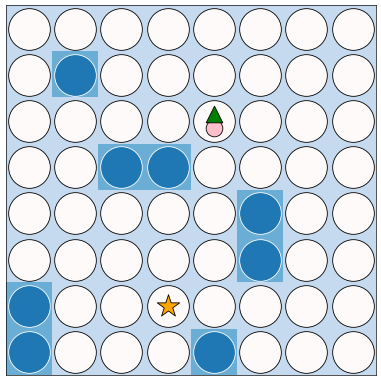

In [4]:
rng_key = jax.random.PRNGKey(seed)
rng_env, rng_layer1, rng_layer2, rng_outer = jax.random.split(rng_key, 4)
env = utils.FrozenLake.make_random(rng_env, (map_size, map_size), 0.8)
env_state, obs = env.reset(rng_key)
plotting.render(env, env_state)

# outer policy

In [5]:
def setup_outer_layer(rng_key, lower_layer, lr, replay_capacity):
    lower_state, obs = lower_layer.reset(rng_key)
    action = lower_layer.action_space.sample(rng_key)
    sample_transition = utils.Transition(lower_state, obs, action, 0.0, obs, False, {})

    qnet = utils.ConvNet(
        hidden=[2 * map_size] * int(np.log2(map_size)), out=lower_layer.action_space.n
    )
    dql_state = qlearning.DQLTrainState.create(rng_key, qnet, obs, lr)
    replay_memory = replay.CircularBuffer.create(sample_transition, replay_capacity)
    return dql_state, replay_memory

In [6]:
q_learning_step = partial(
    qlearning.q_learning_step, rollout_length=rollout_length, train_iter=train_iter
)

rng_setup, rng_sim = jax.random.split(rng_outer)
rng_sim = jax.random.split(rng_sim, n_rollouts)

# setup the outer layer
dql_state_out, replay_memory_out = setup_outer_layer(
    rng_setup, lower_layer=env, lr=lr, replay_capacity=2**14
)

# train the outer layer
(env, dql_state_out, replay_memory_out), results = jax.lax.scan(
    q_learning_step, (env, dql_state_out, replay_memory_out), rng_sim
)

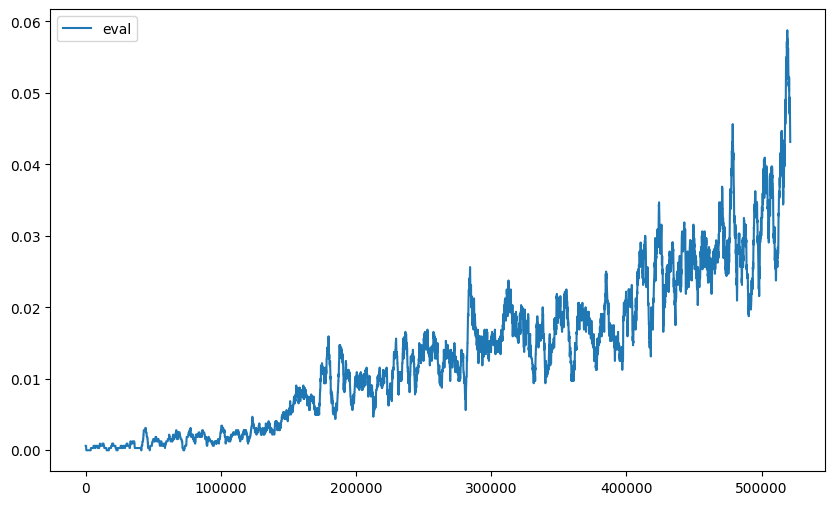

In [7]:
def smooth(r, w=50):
    filter = jnp.ones(w) / w
    return jnp.convolve(r, filter, mode="valid")


plt.figure(figsize=(10, 6))
r = smooth(results.eval_reward.mean(axis=-1))
plt.plot(results.eval_reward.shape[-1] * jnp.arange(1, 1 + len(r)), r, label="eval")
plt.legend()

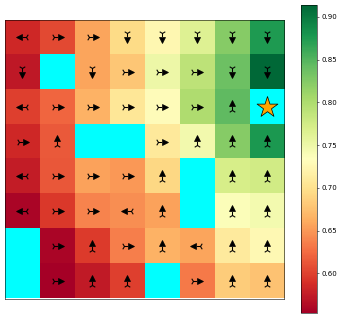

In [10]:
rng_key = jax.random.PRNGKey(0)
rng_env_reset, rng_steps = jax.random.split(rng_key)

plt.figure(figsize=((map_size + 1), map_size), dpi=50)
get_qval_fn = partial(dql_state_out.qval_apply_fn, dql_state_out.params_qnet)
plotting.plot_qvals(env, get_qval_fn, rng_reset=rng_env_reset, hold=True)